# Load the Gan and the Diffusion to compare

Using device: cpu


/home/vasilis/Documents/Envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_110091/3604878920.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

GAN Model loaded successfully.
Evaluation Metrics:
MSE: 0.001872
Chi^2 Mean: 3.637759


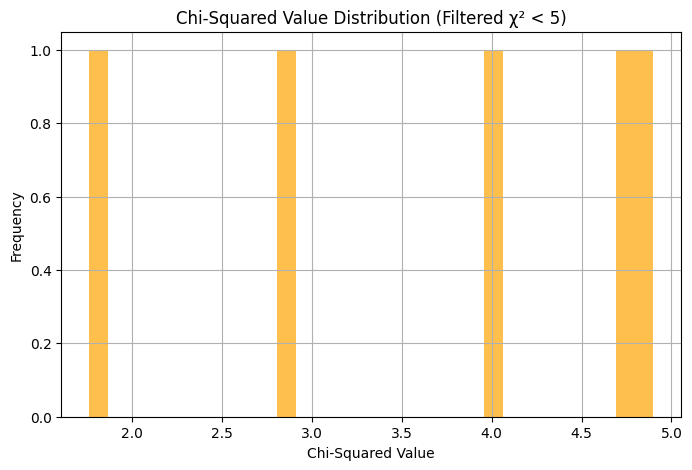

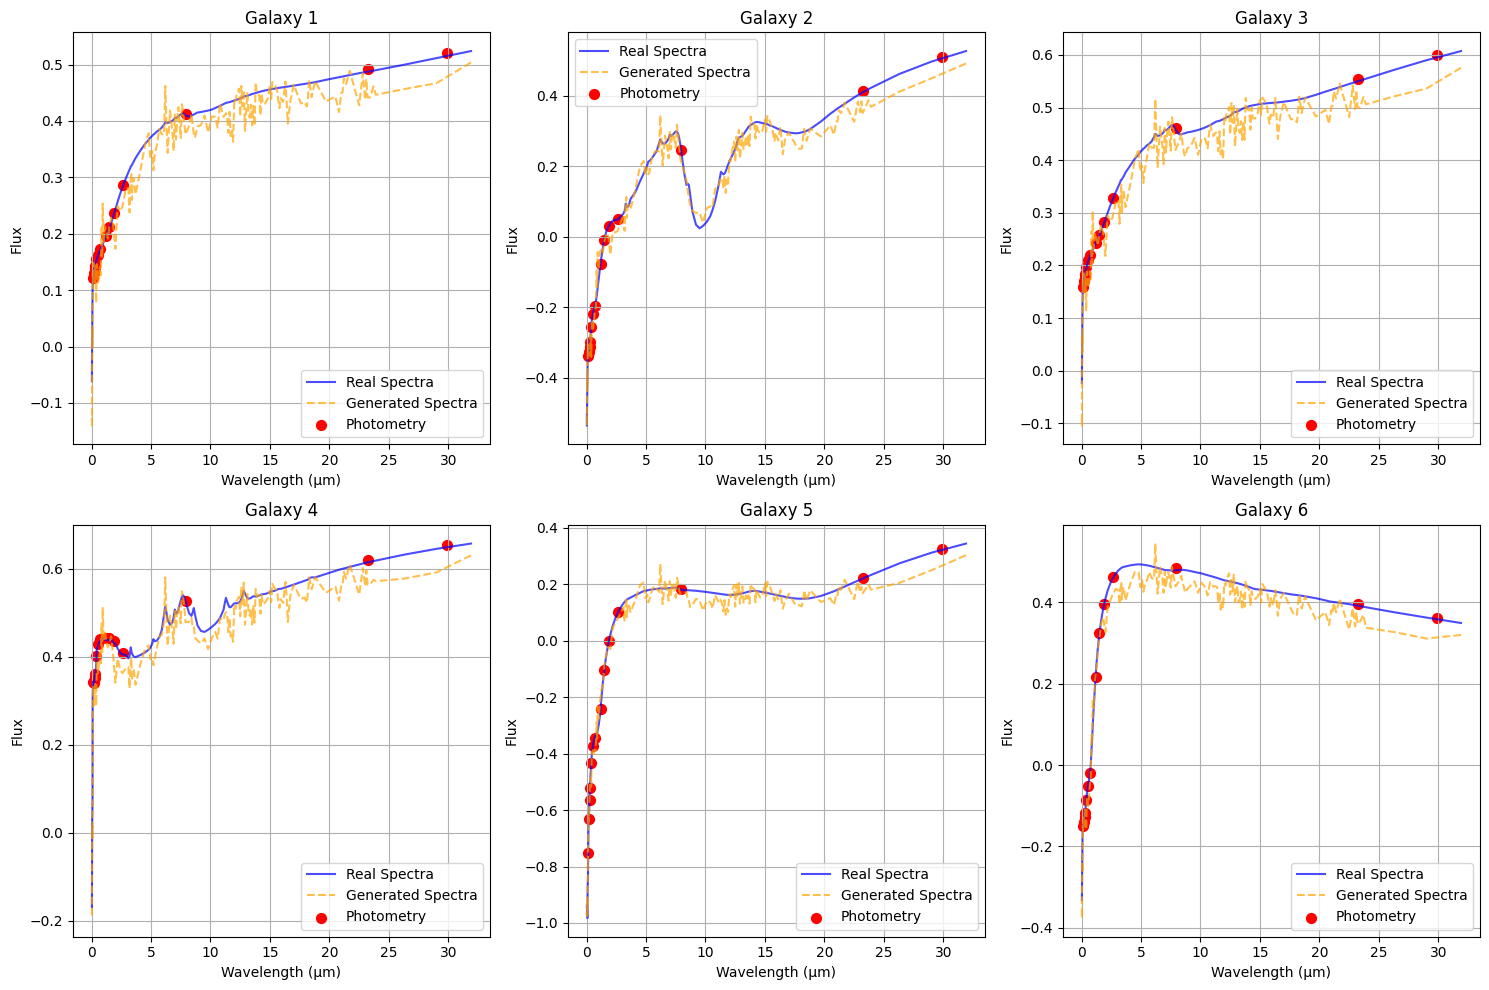

Diffusion Model loaded successfully.


/home/vasilis/Documents/Envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_110091/3604878920.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

RuntimeError: Given groups=1, weight of size [32, 17, 3], expected input[1, 32, 17] to have 17 channels, but got 32 channels instead

In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
from GANS.src.model import PhotometryToSpectraModel
from DIFFUSION_MODELS.tsdiff import SelfGuidedTSDiff  # Diffusion model import
from GANS.src.data_loader import load_data
from GANS.config.hyperparameters import DEVICE, PHOTOMETRY_DIM, SPECTRA_DIM, LATENT_DIM, TRANSFORMER_HIDDEN_DIM, TRANSFORMER_NHEAD, TRANSFORMER_LAYERS
from torch.utils.data import DataLoader, TensorDataset

def calculate_chi2(real_spectra, generated_spectra):
    uncertainty = 0.1  # Assumed uncertainty as 10% of values
    diff = real_spectra - generated_spectra
    denom = (uncertainty * real_spectra) ** 2 + (uncertainty * generated_spectra) ** 2
    chi2 = torch.sum((diff ** 2) / denom, dim=1) / real_spectra.size(1)
    return chi2

def evaluate_model(model, test_dataloader, device, spectra_wavelengths, photometry_wavelengths, random_galaxies=False, num_samples=6):
    model.eval()
    all_real_spectra, all_generated_spectra, all_photometry_data = [], [], []
    
    with torch.no_grad():
        for photometry_data, real_spectra in test_dataloader:
            photometry_data, real_spectra = photometry_data.to(device), real_spectra.to(device)

            # Check the type of model and call the appropriate method
            if isinstance(model, PhotometryToSpectraModel):  # GAN model
                generated_spectra = model.forward_generator(photometry_data)  # Use forward_generator for GAN
            else:  # Diffusion model (SelfGuidedTSDiff)
                t = torch.tensor([0.0]).to(device)  # Set t to a fixed value, for example, a tensor with one element
                generated_spectra = model(photometry_data, t)  # Pass t to forward() for Diffusion
            
            all_real_spectra.append(real_spectra)
            all_generated_spectra.append(generated_spectra.squeeze(-1))
            all_photometry_data.append(photometry_data)

    # Concatenate the results
    all_real_spectra = torch.cat(all_real_spectra)
    all_generated_spectra = torch.cat(all_generated_spectra)
    all_photometry_data = torch.cat(all_photometry_data)

    # Filter wavelengths for < 35
    valid_spectra_indices = spectra_wavelengths < 35
    valid_photometry_indices = photometry_wavelengths < 35

    filtered_spectra_wavelengths = spectra_wavelengths[valid_spectra_indices]
    filtered_photometry_wavelengths = photometry_wavelengths[valid_photometry_indices]

    # Filter the spectra data
    all_real_spectra = all_real_spectra[:, valid_spectra_indices]
    all_generated_spectra = all_generated_spectra[:, valid_spectra_indices]
    all_photometry_data = all_photometry_data[:, valid_photometry_indices]

    # Calculate chi-squared values
    chi2_values = calculate_chi2(all_real_spectra, all_generated_spectra)

    if random_galaxies:
        random_indices = random.sample(range(len(all_real_spectra)), num_samples)
    else:
        random_indices = list(range(num_samples))

    # Extract chi-squared values for the selected galaxies
    selected_chi2_values = chi2_values[random_indices]

    # Filter chi-squared values to include only those < 5
    filtered_chi2_values = selected_chi2_values[selected_chi2_values < 5]

    # Calculate evaluation metrics
    mse = mean_squared_error(all_real_spectra.cpu().numpy(), all_generated_spectra.cpu().numpy())
    chi2_mean = torch.mean(filtered_chi2_values).item()

    print(f"Evaluation Metrics:\nMSE: {mse:.6f}\nChi^2 Mean: {chi2_mean:.6f}")

    # Plot Chi-Squared distribution for filtered values
    plt.figure(figsize=(8, 5))
    plt.hist(filtered_chi2_values.cpu().numpy(), bins=30, color='orange', alpha=0.7)
    plt.xlabel('Chi-Squared Value')
    plt.ylabel('Frequency')
    plt.title('Chi-Squared Value Distribution (Filtered χ² < 5)')
    plt.grid(True)
    plt.savefig("chi2_distribution_filtered.png")
    plt.show()

    # Create a single plot with 6 subplots for the first 6 samples
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 samples
    axes = axes.flatten()  # Flatten to make indexing easier

    for i in range(min(num_samples, len(random_indices))):  # Plot the first 6 samples
        real_sample = all_real_spectra[random_indices[i], :].cpu().numpy()
        photometry_data = all_photometry_data[random_indices[i], :].cpu().numpy()
        generated_sample = all_generated_spectra[random_indices[i], :].cpu().numpy()

        axes[i].plot(filtered_spectra_wavelengths, real_sample, label='Real Spectra', color='blue', alpha=0.7)
        axes[i].plot(filtered_spectra_wavelengths, generated_sample, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
        axes[i].scatter(filtered_photometry_wavelengths, photometry_data, label='Photometry', color='red', s=50)
        axes[i].set_title(f'Galaxy {i+1}')
        axes[i].set_xlabel('Wavelength (µm)')
        axes[i].set_ylabel('Flux')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig("eval_with_metrics_subplots.png")  # Save the combined figure with 6 subplots
    plt.show()


# --- Main script to load models and data ---
if __name__ == "__main__":
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data (same for both models)
    photometry_data, spectra_data = load_data(device)

    # Extract wavelengths using the newly defined load_data_eval function
    spectra_wavelengths, photometry_wavelengths = load_data_eval(device)

    # Load the test dataset
    test_dataset = TensorDataset(photometry_data, spectra_data)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load and evaluate GAN model
    gan_model = PhotometryToSpectraModel(
        photometry_dim=PHOTOMETRY_DIM,
        spectra_dim=SPECTRA_DIM,
        latent_dim=LATENT_DIM,
        transformer_hidden_dim=TRANSFORMER_HIDDEN_DIM,
        transformer_nhead=TRANSFORMER_NHEAD,
        transformer_layers=TRANSFORMER_LAYERS
    ).to(device)

    gan_model.load_state_dict(torch.load("/home/vasilis/Documents/AstroInformatics/GANS/gan_model.pth", map_location=torch.device('cpu')))  # Load GAN model
    print("GAN Model loaded successfully.")

    # Evaluate GAN model
    evaluate_model(
        gan_model,
        test_dataloader=test_dataloader,
        device=device,
        spectra_wavelengths=spectra_wavelengths,
        photometry_wavelengths=photometry_wavelengths
    )

    # Load and evaluate Diffusion model
    diffusion_model = SelfGuidedTSDiff(input_dim=17, time_steps=1000).to(device)  # Change according to your model
    diffusion_model.load_state_dict(torch.load("/home/vasilis/Documents/AstroInformatics/DIFFUSION_MODELS/trained_model.pth", map_location=torch.device('cpu')))  # Load Diffusion model
    print("Diffusion Model loaded successfully.")

    # Evaluate Diffusion model
    evaluate_model(
        diffusion_model,
        test_dataloader=test_dataloader,
        device=device,
        spectra_wavelengths=spectra_wavelengths,
        photometry_wavelengths=photometry_wavelengths
    )